# fSim gate simulation

here we simulate an fSim gate, focusing on the unitary that is being performed when we play a particular sequence of pulses. We start with the Hamiltonian:

$$
H = \sum_{i=1,2} \left( (\omega_i + \delta \omega_i(t)) a_i^\dagger a_i + \frac{\eta}{2}a^{\dagger 2}_i a^2_i \right) \\
+ g(t)(a_1^\dagger a_2 + a_2^\dagger a_1) \\
+ \sum_{i=1,2} \frac{\Omega_i(t)}{2}(a_i + a_i^\dagger).
$$

Here $g(t)$ is a time controlled coupling term, $\Omega_i(t)$ is a single qubit drive term, $\omega_i$ are the 01 transition frequencies, $\delta\omega_i(t)$ is the controlled time dependent detuning and $\eta$ is the anharmonicity.

An implicit assumption in quantum computing is that all qubits have the same transition frequency, and therefore one can switch to a common frame of reference where there is no dynamics when no gates are being executed. But in a real SC qubit system, the frequencies are different and the only way to perform an interaction is to bring certain transitions to be on resonance for a limited amount of time. However, because the qubits evolve in the lab frame at different rates, this can introduce an interaction that depends on the execution time of the gate, which needs to be compensated. This is what we show here.

In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

## iSWAP gate

To demonstrate an iSWAP gate operation we start with a truncated 2 dimensional hilbert space and remove the anharmonic part ($\eta=0$). We then switch to the rotating frame with the transformation Hamiltonian
$
H_0 = \sum_{i=1,2}\omega_i n_i
$,
where $n_i = a_i^\dagger a_i$.
In this frame, the Hamiltonian becomes:

$$
H_1^i = \sum_{i=1,2}  \delta \omega_i(t) n_i  \\
+ g(t)(a_1^\dagger a_2 e^{-i\Delta t} + a_2^\dagger a_1 e^{i\Delta t}) \\
+ \sum_{i=1,2} \frac{\Omega_i(t)}{2}(a_i e^{i\omega_i t} + a_i^\dagger e^{-i\omega_i t}).
$$

In practice, only the first and 2nd terms or the 3rd term will be "on" (non-zero) at a given time, when performing an iSWAP or a single qubit gate, respectively. Let's focus on the iSWAP case. Here, we can define raising and lowering operators as well as a Z operator in the SWAP space $\{|S_0> = |1,0>, |S_1> = |0,1>\}$:

$$
J_+ = a_2^\dagger a_1 \\
J_- = a_1^\dagger a_2 \\
J_z = (n_2 - n_1) /2
$$

These operators function as Pauli operators in the SWAP space, namely $[J_z, J_+] = J_+$ and so on.
Let's assume that we detune the qubits to be at the center point when doing an iSWAP for simplicity, i.e $\delta\omega_2 = -\delta\omega_1$. Then the iSWAP Hamlitonian becomes:

$$
H_1^i(t=\mathrm{iSWAP}) = -\Delta J_z + g(J_+ e^{i\Delta t} + J_- e^{-i\Delta t}) 
$$

where $\Delta = \omega_2 - \omega_1$ (this will give us $\omega_1 + \delta\omega_1 = \omega_2 + \delta \omega_2 $).
Let's define operators and look at their matrix representation:

In [2]:
# Single qubit Hilbert space dimension
Nh = 2

# operator definitions

a = qp.destroy(Nh)
I = qp.qeye(Nh)

a1 = qp.tensor([a, I])
a2 = qp.tensor([I, a])

n1 = a1.dag() * a1
n2 = a2.dag() * a2

# static part of interaction Hamiltonian
H01 = 0 * n1
if Nh == 3:  # anharmonicity
    H01 += (eta/2)*(a1.dag()**2*a1**2 + a2.dag()**2*a2**2) 

# dynamic coupling interaction operators
J_minus = a1.dag() * a2
J_plus = a2.dag() * a1

# dynamic detuning operator
J_z = (n2 - n1)/2

In [3]:
print(J_z)
print(J_minus)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0. ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]


In [4]:
S0= qp.fock([2, 2], [1,0])
S1 = qp.fock([2, 2], [0,1])

In [5]:
J_minus * S1 == S0

True

We see that they behave like real pauli operators in the swap space.

## Conneting to the quantum computing iSWAP operator

the quantum computing iSWAP operator is:

Let's start with some general parameters:

In [54]:
# general parameters

# qubit parameters
omega1 = 2*np.pi*6.05  # GHz
omega2 = 2*np.pi*5.95  # GHz
Delta = omega2 - omega1
omega_av = (omega1 + omega2) / 2
eta = 2*np.pi*0.3  # GHz

# transfomration to rotating frame Hamiltonian
H00 = omega1 * a1.dag() * a1 + omega2 * a2.dag() * a2

In [55]:
iswap = lambda t1, angle: (-1j*(J_plus * np.exp(1j * Delta * t1) + J_minus * np.exp(-1j * Delta * t1)) * 0.5 * angle).expm()
iswap(0, np.pi)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

Now, the question is: What is the difference between the quantum computing iSWAP and the unitary we get from exponentiating over the Hamlitonian?

The unitary, started at time $t_1$ and up to time $t_2$, is:

$$
U(t_1, t_2) = \mathcal{T}\exp\left(-i \int_{t_1}^{t_2} dt \left(-\Delta J_z + g(t)(J_+ e^{i\Delta t} + J_- e^{-i\Delta t})\right)  \right)
$$

In order to solve this integral, we will go to the rotating frame with $H_0 = -\Delta J_z$. Then the Hamiltonian becomes:

$$
H^I = 
\begin{cases}
g(J_+ e^{i\Delta t_1} + J_- e^{-i\Delta t_1}), & t_1 < t < t_2 \\
0, & \mathrm{else}
\end{cases}
$$

This can be easily expontentiated to give

$$
U^I(t_2, t_1) = e^{-iH^I t} = \cos\theta -i(J_+ e^{i\Delta t_1} + J_- e^{-i\Delta t_1})\sin\theta
$$

where $\theta = g(t_2-t_1)$ (TODO: verify factor of 2 here).

To go back to the original frame we observe that $|\psi^I(t_1)> = |\psi^S(t_1)>$ and $|\psi^I(t_2)> = U^I(t_2, t_1)|\psi^S(t_1)>$.

Since $|\psi(t_2)^I> = e^{iH_0(t_2-t_1)}|\psi(t_2)^S>$, we get:

$$
\mathrm{iSWAP_{pulse}} \equiv U^S(t_2, t_1) = e^{iH_0(t_2-t_1)}U^I(t_2, t_1) \\
= e^{-i\Delta J_z(t_2-t_1)}\left(\cos\theta -i(J_+ e^{i\Delta t_1} + J_- e^{-i\Delta t_1})\sin\theta\right)
$$

The result is:
$$
\mathrm{iSWAP_{pulse}} =
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & e^{i\Delta(t_2-t_1)/2} \cos(\theta) & -i e^{i\Delta(t_2+t_1)/2} \sin(\theta) & 0 \\
    0 & -i e^{-i\Delta(t_2+t_1)/2} \sin(\theta) & e^{-i\Delta(t_2-t_1)/2} \cos(\theta) & 0 \\
    0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

We see that the actual iSWAP depends on $t_2 - t_1$, the gate duration, and $(t_1 + t_2)/2$, the gate midpoint in time. Thus it is not independent to time shifts, and we need to find pulses before and after to correct for this effect.

## Simulation and comparison to analytical result

Let's simualte this sequence and compare to analytical results. For concreteness, we start by applying two -Y/2 pulses to get to the state $|x,x>$.
We then apply the gate in simulation, and compare the result to our analytical calculation.

In [56]:
# solve schrodinger equation with initial state 00 and pi/2 pulse on qubit 1

# pulse parameters
pi_factor1 = 1
pi_factor2 = 0

ts1 = 0
single_pulse_duration = 40  # nsec

t_final = 125
psi0 = qp.fock([Nh, Nh], [0, 0])
args_dict = {
    't_start_swap': 63.32123,
    'swap_angle': np.pi,
    'swap_duration': 22.42423,
    'ts2': 133.32132
    }

Let's run the simulation:

In [57]:
# time dependent functions
def g(t, **args):
    if args['t_start_swap'] < t and t < args['t_start_swap'] + args['swap_duration']:
        return 0.5 * args['swap_angle'] / args['swap_duration']
    else:
        return 0


def g_plus(t, args):
    return g(t, **args) * np.exp(1j * Delta * t)


def g_minus(t, args):
    return g(t, **args) * np.exp(-1j * Delta * t)


def detun(t, args):
    t1 = args['t_start_swap']
    t2 = args['t_start_swap'] + args['swap_duration']
    if  t1 < t and t < t2:
        return -Delta
    else:
        return 0


def cosine_pulse(t, t_start, duration):
    return 0.5 * np.pi * np.pi * np.cos(2*np.pi*(t - t_start - duration/2)/(2*duration)) / duration


def q1_drive(t, **args):  # this is the baseband signal
    if ts1 < t and t < ts1 + single_pulse_duration:
        return pi_factor1 * cosine_pulse(t, ts1, single_pulse_duration)
#     if args['ts2'] < t and t < args['ts2'] + single_pulse_duration:
#         return pi_factor1 * cosine_pulse(t, args['ts2'], single_pulse_duration)
    else:
        return 0

    
def q2_drive(t, **args):  # this is the baseband signal
    if ts1 < t and t < ts1 + single_pulse_duration:
        return pi_factor2 * cosine_pulse(t, ts1, single_pulse_duration)
#     if ts2 < t and t < ts2 + single_pulse_duration:
#         return pi_factor2 * cosine_pulse(t, ts2, single_pulse_duration)
    else:
        return 0


# functions for a, adag operator coefficients (currently only -Y/2)
def a1_dr(t, args):
    return 0.5 * -1j * q1_drive(t, **args)


def a1d_dr(t, args):
    return 0.5 * 1j  * q1_drive(t, **args)


def a2_dr(t, args):
    return 0.5 * -1j * q2_drive(t, **args)


def a2d_dr(t, args):
    return 0.5 * 1j * q2_drive(t, **args)


H = [H01,
     [J_minus, g_minus],
     [J_plus, g_plus],
     [J_z, detun],
     [a1, a1_dr],
     [a1.dag(), a1d_dr],
     [a2, a2_dr],
     [a2.dag(), a2d_dr],
    ]

# integrate
tvec = np.arange(0, t_final, 0.2)
sol = qp.sesolve(H, psi0, tvec,
                 args=args_dict,
#                  e_ops = [a1.dag()*a1,
#                           a2.dag()*a2,                      
#                          ],
                 options=qp.Options(max_step=1))

Text(0.5, 0, 'time [nsec]')

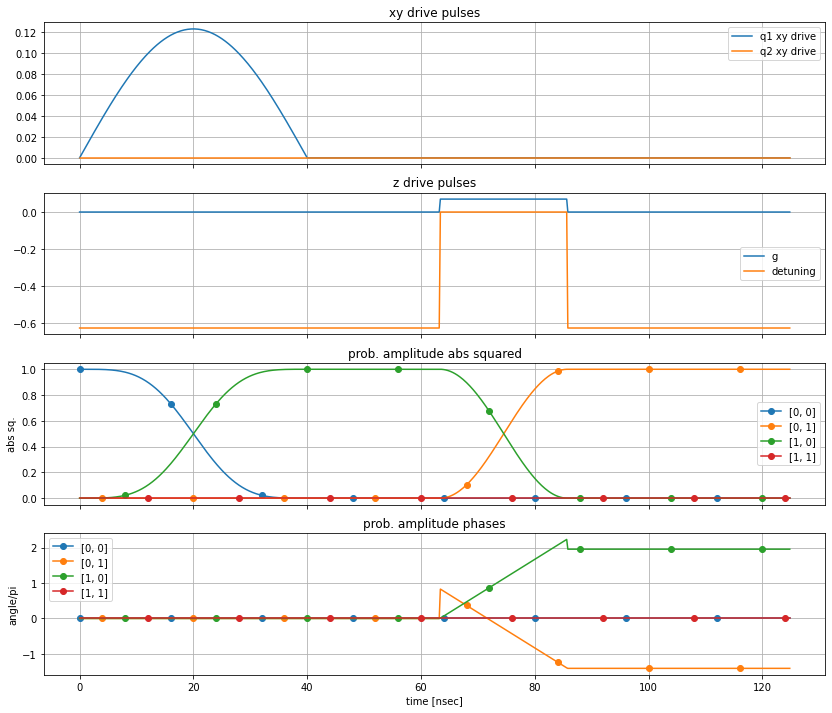

In [58]:

fig, ax = plt.subplots(4, 1, sharex='all', figsize=(14, 12))

axn = ax[0]
axn.plot(sol.times, [q1_drive(t) for t in sol.times], label='q1 xy drive')
axn.plot(sol.times, [q2_drive(t) for t in sol.times], label='q2 xy drive')
axn.legend()
axn.set_title('xy drive pulses')
axn.grid('all')

axn = ax[1]
axn.plot(sol.times, [g(t, **args_dict) for t in sol.times], label='g')
axn.plot(sol.times, [Delta + detun(t, args_dict) for t in sol.times], label='detuning')
axn.legend()
axn.set_title('z drive pulses')
axn.grid('all')

axn = ax[2]
slist = [[0,0], [0,1], [1,0], [1,1]]
for i in range(4):
    axn.plot(sol.times, [np.squeeze(np.abs(s[i])**2) for s in sol.states],
             label=str(slist[i]),
             marker='o',
             markevery=slice(20*i, -1, 80),
            )
axn.legend()
axn.set_ylabel('abs sq.')
axn.grid('all')
axn.set_title('prob. amplitude abs squared')

# phases
axn = ax[3]
# intrinsic phases
for i in range(4):
    axn.plot(sol.times, np.unwrap([np.squeeze(np.angle(s[i])) for s in sol.states])/np.pi,
             label=str(slist[i]),
             marker='o',
             markevery=slice(20*i, -1, 80),
            )

#axn.set_yticks(np.arange(-1, 1.25, 0.25))
axn.grid('all')
axn.legend()
axn.set_ylabel('angle/pi')
axn.set_title('prob. amplitude phases')

ax[-1].set_xlabel('time [nsec]')


The final state is:

In [59]:
print(sol.states[-1])

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 1.48131632e-05+0.00000000e+00j]
 [-2.89008402e-01+9.57326560e-01j]
 [ 1.59523575e-05-2.39122341e-06j]
 [ 0.00000000e+00+0.00000000e+00j]]


In [60]:
# explicit calculation of the unitary
t1 = args_dict['t_start_swap']
t2 = args_dict['swap_duration'] + args_dict['t_start_swap']
angle = args_dict['swap_angle']

initial_state = 0.5 * np.array([1] * 4)

# here we don't calculate the matrix exponents yet
brute_force_unitary = (1j*Delta*(t2-t1)*J_z).expm() * iswap(t1, angle)

In [61]:
brute_force_unitary

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.28902478+0.95732162j
   0.        +0.j        ]
 [ 0.        +0.j          0.28902478+0.95732162j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

We see that the brute force unitary gives the same final state as the numerical simulation:

In [62]:
print(brute_force_unitary * initial_state)

[ 0.5       +0.j         -0.14451239+0.47866081j  0.14451239+0.47866081j
  0.5       +0.j        ]


Now let's calculate the iSWAP unitary from the matrix representation and see that we indeed get the same result again:

In [63]:

angle = args_dict['swap_angle']
unitary = qp.qeye([2, 2]) * np.cos(angle/2) -1j * (J_plus * np.exp(1j*Delta*(t2)) + J_minus * np.exp(-1j*Delta*(t2))) * np.sin(angle/2)
unitary = np.array([
    [1, 0, 0, 0],
    [0, np.exp(1j*Delta*(t2-t1)/2) * np.cos(angle/2), -1j * np.exp(1j*Delta*(t2+t1)/2) * np.sin(angle/2), 0],
    [0, -1j * np.exp(-1j*Delta*(t2+t1)/2) * np.sin(angle/2), np.exp(-1j*Delta*(t2-t1)/2) * np.cos(angle/2), 0],
    [0, 0, 0, 1]
])
unitary @ initial_state

array([ 0.5       +0.j        , -0.14451239+0.47866081j,
        0.14451239+0.47866081j,  0.5       +0.j        ])

## Correcting for time-dependent phases

In order to maintain the qubit in the original rotating frame before and after the iSWAP, we need to detune the qubits to compensate for two phase offsets:

1. the phase error because the interaction term is $J_+e^{i\Delta t} + \mathrm{h.c.}$ instead of $J_+ + \mathrm{h.c.}$ 
2. the phase error acquired becase we detuned the qubit for a certain amount of time, given by $\Delta(t_2 - t_1)$.

It's not difficult to show that the transformation that corrects $\mathrm{iSWAP_{pulse}}$ is therefore:

TODO: verify plus minus signs here!

$$
\mathrm{iSWAP_{gate}} = \exp(-iJ_z\Delta (t_2-t_1))\exp(-iJ_z\varphi_1))\mathrm{iSWAP_{pulse}}\exp(iJ_z\varphi_1))
$$

where $\varphi_1 = \Delta t_1 \mod 2\pi$.

Here we play the same sequence as before, but now we also add correcting detuning pulses before and after:

In [66]:
# time dependent functions
def g(t, **args):
    if args['t_start_swap'] < t and t < args['t_start_swap'] + args['swap_duration']:
        return 0.5 * args['swap_angle'] / args['swap_duration']
    else:
        return 0


def g_plus(t, args):
    return g(t, **args) * np.exp(1j * Delta * t)


def g_minus(t, args):
    return g(t, **args) * np.exp(-1j * Delta * t)


def detun(t, args):
    t1 = args['t_start_swap']
    t2 = args['t_start_swap'] + args['swap_duration']
    tau = t2 - t1
    tau_before = tau / 5
    tau_after = tau / 5
    if t1 - tau_before < t < t1:
        return (Delta * t1 % (2 * np.pi)) / tau_before
    if t1 < t < t2:
        return -Delta
    elif t2 < t < t2 + tau_after:
        return Delta * tau / tau_after
    elif t2 + tau_after < t < t2 + tau_before + tau_after:
        return -(Delta * t1 % (2 * np.pi)) / tau_before
    else:
        return 0


def cosine_pulse(t, t_start, duration):
    return 0.5 * np.pi * np.pi * np.cos(2*np.pi*(t - t_start - duration/2)/(2*duration)) / duration


def q1_drive(t, **args):  # this is the baseband signal
    if ts1 < t < ts1 + single_pulse_duration:
        return pi_factor1 * cosine_pulse(t, ts1, single_pulse_duration)
#     if args['ts2'] < t and t < args['ts2'] + single_pulse_duration:
#         return pi_factor1 * cosine_pulse(t, args['ts2'], single_pulse_duration)
    else:
        return 0

    
def q2_drive(t, **args):  # this is the baseband signal
    if ts1 < t and t < ts1 + single_pulse_duration:
        return pi_factor2 * cosine_pulse(t, ts1, single_pulse_duration)
#     if ts2 < t and t < ts2 + single_pulse_duration:
#         return pi_factor2 * cosine_pulse(t, ts2, single_pulse_duration)
    else:
        return 0


# functions for a, adag operator coefficients (currently only -Y/2)
def a1_dr(t, args):
    return 0.5 * -1j * q1_drive(t, **args)


def a1d_dr(t, args):
    return 0.5 * 1j  * q1_drive(t, **args)


def a2_dr(t, args):
    return 0.5 * -1j * q2_drive(t, **args)


def a2d_dr(t, args):
    return 0.5 * 1j * q2_drive(t, **args)


H = [H01,
     [J_minus, g_minus],
     [J_plus, g_plus],
     [J_z, detun],
     [a1, a1_dr],
     [a1.dag(), a1d_dr],
     [a2, a2_dr],
     [a2.dag(), a2d_dr],
    ]

# integrate
tvec = np.arange(0, t_final, 0.2)
sol = qp.sesolve(H, psi0, tvec,
                 args=args_dict,
#                  e_ops = [a1.dag()*a1,
#                           a2.dag()*a2,                      
#                          ],
                 options=qp.Options(max_step=1))

Text(0.5, 0, 'time [nsec]')

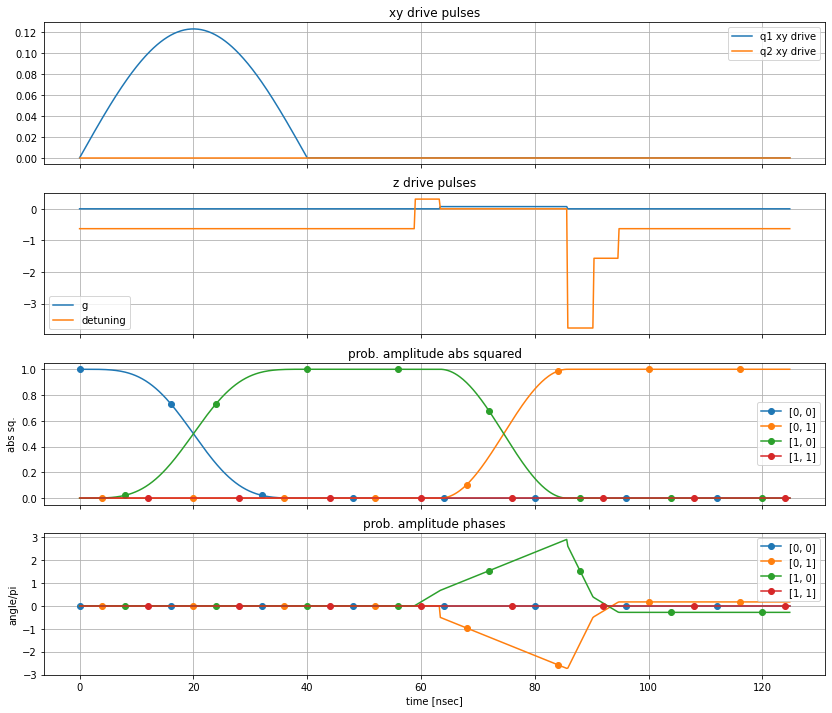

In [67]:

fig, ax = plt.subplots(4, 1, sharex='all', figsize=(14, 12))

axn = ax[0]
axn.plot(sol.times, [q1_drive(t) for t in sol.times], label='q1 xy drive')
axn.plot(sol.times, [q2_drive(t) for t in sol.times], label='q2 xy drive')
axn.legend()
axn.set_title('xy drive pulses')
axn.grid('all')

axn = ax[1]
axn.plot(sol.times, [g(t, **args_dict) for t in sol.times], label='g')
axn.plot(sol.times, [Delta + detun(t, args_dict) for t in sol.times], label='detuning')
axn.legend()
axn.set_title('z drive pulses')
axn.grid('all')

axn = ax[2]
slist = [[0,0], [0,1], [1,0], [1,1]]
for i in range(4):
    axn.plot(sol.times, [np.squeeze(np.abs(s[i])**2) for s in sol.states],
             label=str(slist[i]),
             marker='o',
             markevery=slice(20*i, -1, 80),
            )
axn.legend()
axn.set_ylabel('abs sq.')
axn.grid('all')
axn.set_title('prob. amplitude abs squared')

# phases
axn = ax[3]
# intrinsic phases
for i in range(4):
    axn.plot(sol.times, np.unwrap([np.squeeze(np.angle(s[i])) for s in sol.states])/np.pi,
             label=str(slist[i]),
             marker='o',
             markevery=slice(20*i, -1, 80),
            )

#axn.set_yticks(np.arange(-1, 1.25, 0.25))
axn.grid('all')
axn.legend()
axn.set_ylabel('angle/pi')
axn.set_title('prob. amplitude phases')

ax[-1].set_xlabel('time [nsec]')


## Appendix: Does the analytical derivation for the exponent of a Pauli matrix also give us the abrupt pi/2 phase jumps?

The answer is YES.

In [18]:
sx = 0.1*qp.sigmax()
psis0 = qp.fock(2)
sols = qp.sesolve(0.5*sx, psis0, tvec)

Text(0.5, 1.0, 'angle|psi| using sesolve')

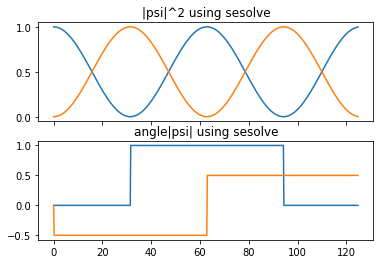

In [19]:
fig, ax = plt.subplots(2, 1, sharex='all')
for i in range(2):
    ax[0].plot(tvec, [np.squeeze(np.abs(s[i])**2) for s in sols.states])
    ax[1].plot(tvec, np.unwrap(np.squeeze([np.angle(s[i]) for s in sols.states]))/np.pi)
ax[0].set_title('|psi|^2 using sesolve')
ax[1].set_title('angle|psi| using sesolve')

In [20]:
mats = np.array([(-1j*0.05*t*qp.sigmax()).expm() for t in tvec])

Text(0.5, 1.0, 'angle|psi| using matrix exp')

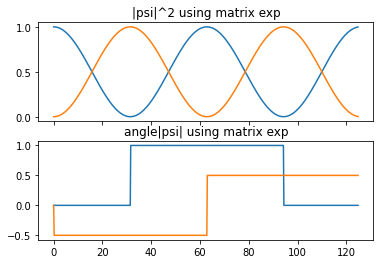

In [21]:
tevo = mats @ np.array([[1], [0]])
fig, ax = plt.subplots(2, 1, sharex='all')
for i in range(2):
    ax[0].plot(tvec, [np.squeeze(np.abs(s[i])**2) for s in tevo])
    ax[1].plot(tvec, np.unwrap(np.squeeze([np.angle(s[i]) for s in tevo]))/np.pi)
ax[0].set_title('|psi|^2 using matrix exp')
ax[1].set_title('angle|psi| using matrix exp')